### Loading Lib

In [1]:
import torch
from torch import nn
from pathlib import Path
import torchvision
from torchvision import transforms,datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import random
from PIL import Image
import matplotlib.pyplot as plt
from pathlib import Path
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Loading data

In [2]:
# dir_path = Path("/kaggle/input/face-shape-dataset/FaceShape Dataset")
# train_dir = dir_path/"training_set"
# test_dir = dir_path/"testing_set"

dir_path = Path("FaceShape Dataset")
train_dir = dir_path/"train"
test_dir = dir_path/"test"
train_dir

WindowsPath('FaceShape Dataset/train')

### Loading random images

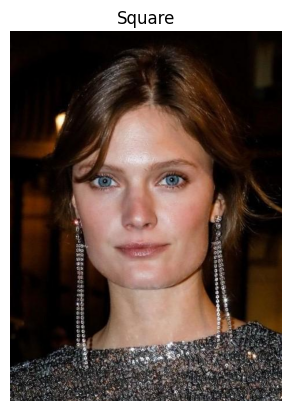

In [3]:
images = list(dir_path.glob("*/*/*.jpg"))

random_img = random.choice(images)
t = random_img.parent.stem
img = Image.open(random_img)
plt.title(t)
plt.imshow(img)
plt.axis('off')
plt.show()

### Creating a data_transform

In [4]:
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.TrivialAugmentWide(31),
    transforms.ToTensor()
])

### Checking Some Random Transform Images 

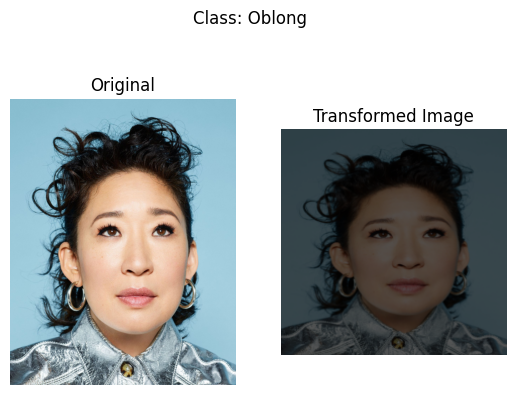

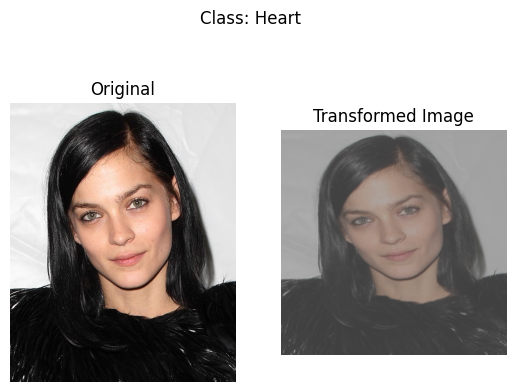

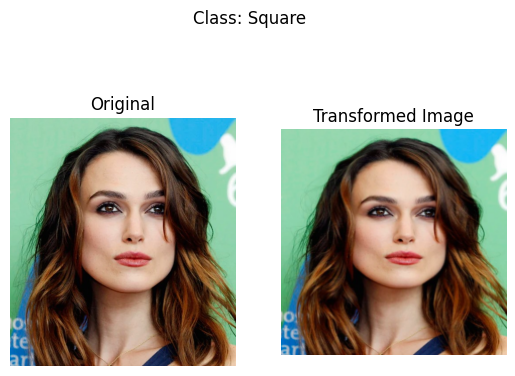

In [5]:
def plot_random(image_path_list,transform,n=3,seed=0):
    # sorted(image_path_list)
    if seed:
        random.seed(seed)
    random_image_paths = random.sample(image_path_list,k=n)

    for i in random_image_paths:
        # t = i.parent.stem
        with Image.open(i) as img:
            fig,ax = plt.subplots(nrows=1,ncols=2)
            ax[0].imshow(img)
            ax[0].set_title("Original")
            ax[0].axis("off")

            transform_img = transform(img)
            ax[1].imshow(transform_img.permute(1,2,0))
            ax[1].set_title("Transformed Image")
            ax[1].axis("off")

            fig.suptitle(f"Class: {i.parent.stem}")
    plt.show()


plot_random(images,data_transforms,3)
# random_image

### Creating Dataset and dataloader

In [6]:
def safe_pil_loader(path):
    try:
        with open(path, 'rb') as f:
            img = Image.open(f)
            return img.convert('RGB')
    except (OSError, SyntaxError):
        return Image.new('RGB', (224, 224))


train_dataset = datasets.ImageFolder(root=train_dir,transform=data_transforms,loader = safe_pil_loader)
train_dataloader = DataLoader(train_dataset,batch_size=32,shuffle=True) 

test_dataset = datasets.ImageFolder(root=test_dir,transform=data_transforms,loader = safe_pil_loader)
test_dataloader = DataLoader(test_dataset,batch_size=32,shuffle=True)

len(train_dataloader)

276

### Finne Tunning the Vit model

In [ ]:
import torch
import torch.nn as nn
from transformers import ViTForImageClassification
from tqdm.auto import tqdm
import numpy as np
import matplotlib.pyplot as plt

# Load model
model = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224-in21k",
    num_labels=5,
    ignore_mismatched_sizes=True
)

# Multi-GPU support
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs")
    model = nn.DataParallel(model)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Unfreeze classifier
classifier_params = model.module.classifier.parameters() if isinstance(model, torch.nn.DataParallel) else model.classifier.parameters()
for param in classifier_params:
    param.requires_grad = True

# Loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Metrics
train_loss_model = []
train_acc_model = []
test_loss_model = []
test_acc_model = []

EPOCHS = 20

# Training loop
for epoch in tqdm(range(EPOCHS)):
    print(f"{epoch + 1}/{EPOCHS}.........")
    model.train()

    train_loss_epoch = 0
    train_acc_epoch = 0

    for batch_idx, (X, y) in enumerate(train_dataloader):
        X, y = X.to(device, non_blocking=True), y.to(device, non_blocking=True)
        outputs = model(X).logits
        loss = loss_fn(outputs, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss_epoch += loss.item()
        acc = (outputs.argmax(1) == y).sum().item() / len(y)
        train_acc_epoch += acc

        if batch_idx % 50 == 0:
            print(f"Batch {batch_idx} | Train loss: {loss.item():.5f} | Train acc: {acc:.2f}")

    train_loss_epoch /= len(train_dataloader)
    train_acc_epoch /= len(train_dataloader)

    model.eval()
    test_loss_epoch = 0
    test_acc_epoch = 0

    with torch.inference_mode():
        for X, y in test_dataloader:
            X, y = X.to(device, non_blocking=True), y.to(device, non_blocking=True)
            y_pred = model(X).logits
            loss = loss_fn(y_pred, y)

            test_loss_epoch += loss.item()
            acc = (y_pred.argmax(1) == y).sum().item() / len(y)
            test_acc_epoch += acc

    test_loss_epoch /= len(test_dataloader)
    test_acc_epoch /= len(test_dataloader)

    print(f"Train loss: {train_loss_epoch:.5f} | Train acc: {train_acc_epoch:.2f} | Test loss: {test_loss_epoch:.5f} | Test acc: {test_acc_epoch:.2f}")

    # ✅ Append epoch-level metrics
    train_loss_model.append(train_loss_epoch)
    train_acc_model.append(train_acc_epoch)
    test_loss_model.append(test_loss_epoch)
    test_acc_model.append(test_acc_epoch)

### Saving the model

In [ ]:
torch.save(model.state_dict(),"/kaggle/working/model_01.pth")

print("Model 1 saved successfully!")

### PLotting Lost Curve

In [ ]:
# Plotting
def plot_loss_curves(train_loss, train_acc, test_loss, test_acc, batches_per_epoch=1):
    num_epochs = len(train_loss)

    epochs = range(num_epochs)
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label='Train Loss', marker='o')
    plt.plot(epochs, test_loss, label='Test Loss', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss Curves')

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, label='Train Accuracy', marker='o')
    plt.plot(epochs, test_acc, label='Test Accuracy', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy Curves')

    plt.show()

plot_loss_curves(train_loss_model, train_acc_model, test_loss_model, test_acc_model, batches_per_epoch=1)


### Predicting on some random images

In [ ]:
import random
import matplotlib.pyplot as plt
import numpy as np

def get_random_test_samples(test_dataloader, num_samples=10):
    test_batch = next(iter(test_dataloader))
    test_images, test_labels = test_batch
    
    random_indices = random.sample(range(len(test_images)), min(num_samples, len(test_images)))
    
    random_images = test_images[random_indices]
    random_labels = test_labels[random_indices]
    resize_transform = transforms.Resize((224, 224))
    random_images = torch.stack([resize_transform(img) for img in random_images])
    return random_images, random_labels

model.eval()

random_images, random_labels = get_random_test_samples(test_dataloader, num_samples=5)

with torch.no_grad():
    random_images = random_images.to(next(model.parameters()).device)
    
    pred_logits = model(random_images).logits
    pred_probs = torch.softmax(pred_logits, dim=1)
    pred_labels = torch.argmax(pred_probs, dim=1)

random_images = random_images.cpu()
random_labels = random_labels.cpu()
pred_labels = pred_labels.cpu()

plt.figure(figsize=(15, 10))
for i, (image, true_label, pred_label) in enumerate(zip(random_images, random_labels, pred_labels)):
    plt.subplot(1, 5, i+1)
    img = image.permute(1, 2, 0).numpy()
    
    if img.max() > 1.0:
        img = img / 255.0
    
    plt.imshow(img)
    
    correct = true_label.item() == pred_label.item()
    color = 'green' if correct else 'red'
    
    plt.title(f"True: {true_label.item()}\nPred: {pred_label.item()}", 
              color=color, fontweight='bold')
    
    if not correct:
        plt.gca().spines['top'].set_color('red')
        plt.gca().spines['bottom'].set_color('red')
        plt.gca().spines['left'].set_color('red')
        plt.gca().spines['right'].set_color('red')
        plt.gca().spines['top'].set_linewidth(3)
        plt.gca().spines['bottom'].set_linewidth(3)
        plt.gca().spines['left'].set_linewidth(3)
        plt.gca().spines['right'].set_linewidth(3)
    
    plt.axis("off")
plt.tight_layout()
plt.show()
_ = get_random_test_samples(test_dataloader, num_samples=10)

### Unfrezzing the last three layers of model so that it can adapt facial features

In [ ]:
import torch
import torch.nn as nn
from transformers import ViTForImageClassification
from tqdm.auto import tqdm
import numpy as np
import matplotlib.pyplot as plt

# Load model
model_2 = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224-in21k",
    num_labels=5,
    ignore_mismatched_sizes=True
)

# Multi-GPU support
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs")
    model_2 = nn.DataParallel(model_2)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_2.to(device)

model_path = "/kaggle/working/model_01.pth"
model_2.load_state_dict(torch.load(model_path))

#unfreezing the last 3 layers 
for param in model_2.module.vit.encoder.layer[-3:].parameters():
    param.requires_grad = True
print("Unfroze last 3 ViT layers!")

# Loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_2.parameters(), lr=1e-5)

# Metrics
train_loss_model_2 = []
train_acc_model_2 = []
test_loss_model_2 = []
test_acc_model_2 = []

EPOCHS = 20

# Training loop
for epoch in tqdm(range(EPOCHS)):
    print(f"{epoch + 1}/{EPOCHS}.........")
    model_2.train()

    train_loss_epoch = 0
    train_acc_epoch = 0

    for batch_idx, (X, y) in enumerate(train_dataloader):
        X, y = X.to(device, non_blocking=True), y.to(device, non_blocking=True)
        outputs = model_2(X).logits
        loss = loss_fn(outputs, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss_epoch += loss.item()
        acc = (outputs.argmax(1) == y).sum().item() / len(y)
        train_acc_epoch += acc

        if batch_idx % 50 == 0:
            print(f"Batch {batch_idx} | Train loss: {loss.item():.5f} | Train acc: {acc:.2f}")

    train_loss_epoch /= len(train_dataloader)
    train_acc_epoch /= len(train_dataloader)

    model_2.eval()
    test_loss_epoch = 0
    test_acc_epoch = 0

    with torch.inference_mode():
        for X, y in test_dataloader:
            X, y = X.to(device, non_blocking=True), y.to(device, non_blocking=True)
            y_pred = model_2(X).logits
            loss = loss_fn(y_pred, y)

            test_loss_epoch += loss.item()
            acc = (y_pred.argmax(1) == y).sum().item() / len(y)
            test_acc_epoch += acc

    test_loss_epoch /= len(test_dataloader)
    test_acc_epoch /= len(test_dataloader)

    print(f"Train loss: {train_loss_epoch:.5f} | Train acc: {train_acc_epoch:.2f} | Test loss: {test_loss_epoch:.5f} | Test acc: {test_acc_epoch:.2f}")


    train_loss_model_2.append(train_loss_epoch)
    train_acc_model_2.append(train_acc_epoch)
    test_loss_model_2.append(test_loss_epoch)
    test_acc_model_2.append(test_acc_epoch)

### Saving the model

In [ ]:
torch.save(model.state_dict(),"/kaggle/working/model_02.pth")

print("Model 2 saved successfully!")

### Plotting Graph

In [7]:
# Plotting
def plot_loss_curves(train_loss, train_acc, test_loss, test_acc, batches_per_epoch=1):
    num_epochs = len(train_loss)

    epochs = range(num_epochs)
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label='Train Loss', marker='o')
    plt.plot(epochs, test_loss, label='Test Loss', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss Curves')

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, label='Train Accuracy', marker='o')
    plt.plot(epochs, test_acc, label='Test Accuracy', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy Curves')

    plt.show()

# plot_loss_curves(train_loss_model_2, train_acc_model_2, test_loss_model_2, test_acc_model_2, batches_per_epoch=32)


### Since Vit not addapting the facial features perfectly there for im going to use the efficientnet_b4 pretrinaed model

In [ ]:
from torchvision import efficientnet_b4

model_3 = efficientnet_b4(pretrained=True, num_classes=5)

# Multi-GPU support
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs")
    model_3 = nn.DataParallel(model_3)

model_3.to(device)

# Freeze all layers
for param in model_3.parameters():
    param.requires_grad = False

# Unfreeze classifier
classifier_params = model_3.module.classifier.parameters() if isinstance(model_3, torch.nn.DataParallel) else model_3.classifier.parameters()
for param in classifier_params:
    param.requires_grad = True

# Loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_3.parameters(), lr=1e-3)

# Metrics
train_loss_model_3 = []
train_acc_model_3 = []
test_loss_model_3 = []
test_acc_model_3 = []
EPOCHS = 20

# Training loop
for epoch in tqdm(range(EPOCHS)):
    print(f"{epoch + 1}/{EPOCHS}.........")
    model_3.train()

    train_loss_epoch = 0
    train_acc_epoch = 0

    for batch_idx, (X, y) in enumerate(train_dataloader):
        X, y = X.to(device, non_blocking=True), y.to(device, non_blocking=True)
        outputs = model_3(X).logits
        loss = loss_fn(outputs, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss_epoch += loss.item()
        acc = (outputs.argmax(1) == y).sum().item() / len(y)
        train_acc_epoch += acc

        if batch_idx % 50 == 0:
            print(f"Batch {batch_idx} | Train loss: {loss.item():.5f} | Train acc: {acc:.2f}")

    train_loss_epoch /= len(train_dataloader)
    train_acc_epoch /= len(train_dataloader)

    model_3.eval()
    test_loss_epoch = 0
    test_acc_epoch = 0

    with torch.inference_mode():
        for X, y in test_dataloader:
            X, y = X.to(device, non_blocking=True), y.to(device, non_blocking=True)
            y_pred = model_3(X).logits
            loss = loss_fn(y_pred, y)

            test_loss_epoch += loss.item()
            acc = (y_pred.argmax(1) == y).sum().item() / len(y)
            test_acc_epoch += acc

    test_loss_epoch /= len(test_dataloader)
    test_acc_epoch /= len(test_dataloader)

    print(f"Train loss: {train_loss_epoch:.5f} | Train acc: {train_acc_epoch:.2f} | Test loss: {test_loss_epoch:.5f} | Test acc: {test_acc_epoch:.2f}")


    train_loss_model_3.append(train_loss_epoch)
    train_acc_model_3.append(train_acc_epoch)
    test_loss_model_3.append(test_loss_epoch)
    test_acc_model_3.append(test_acc_epoch)

### Saving the model

In [ ]:
torch.save(model_3.state_dict(),"/kaggle/working/model_03.pth")
print("Model 3 saved successfully!")

### PLotting Loss Curve

In [ ]:
plot_loss_curves(train_loss_model_3, train_acc_model_3, test_loss_model_3, test_acc_model_3, batches_per_epoch=32)

### Predicting on random images
